In this notebook, we'll try to understand what the model actually *learned*.  We'll do so
on the entire dataset (though if we wanted to be more formal we'd only look at the held-out 
test data).

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

import utils
import pylighter as pl

%load_ext autoreload
%matplotlib inline

Using Theano backend.


### Loading data and model

If you used the rnn notebook to generate results, this should "just work".

In [2]:
%%time
# Load the model data and meta params

tag = 'no-stops'

model = keras.models.load_model('gru-{}.model'.format(tag))

with open('gru-{}.pkl'.format(tag), 'r') as f:
  p = pickle.load(f)

CPU times: user 10.5 s, sys: 319 ms, total: 10.8 s
Wall time: 11.5 s


In [3]:
# Load the dataset
df = pd.read_pickle('../data/final-dataframe-{}.pkl'.format(tag))
df.shape

(23452, 7)

In [4]:
# Load vocabulary dicts.
with open('../data/final-vocab-{}.pkl'.format(tag), 'r') as f:
  _ = pickle.load(f)
  word2idx = _['word2idx']
  idx2word = _['idx2word']
  ranked_list = _['ranked_list']
  del _

In [5]:
# Extract data for evaluation, filter top words and pad.

X = df.ix[:, 'encoded_text'].tolist()
X = utils.filter_top_words(X, p['top_words'])

y = df.ix[:, 'encoded_label'].tolist()

X = keras.preprocessing.sequence.pad_sequences(X, maxlen=p['max_length'], 
      value=p['top_words'], padding='post', truncating='post')
X.shape

(23452, 100)

### Question:  What does the distribution of predicted probablities look like?

In [6]:
%%time

# Get output probabilities for every observation.
df['prob'] = model.predict(X)

CPU times: user 1min 23s, sys: 1.81 s, total: 1min 25s
Wall time: 22.9 s


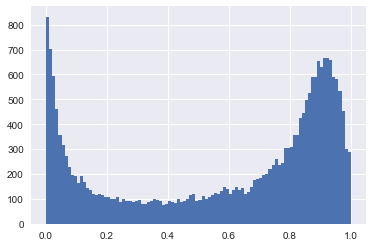

In [7]:
# Look at distribution.  There are some funny extreme modes we should try to understand,
# and a significant percentage of "netural" labels.
_ = df['prob'].hist(bins=100)

### Question:  How did we do at the domain level?  

Meaning, if we average the predicted probability 
over each unique domain with, say, more than 10 observations, and round to 0/1 taking that
as the class label, how many domains did we classify correctly?

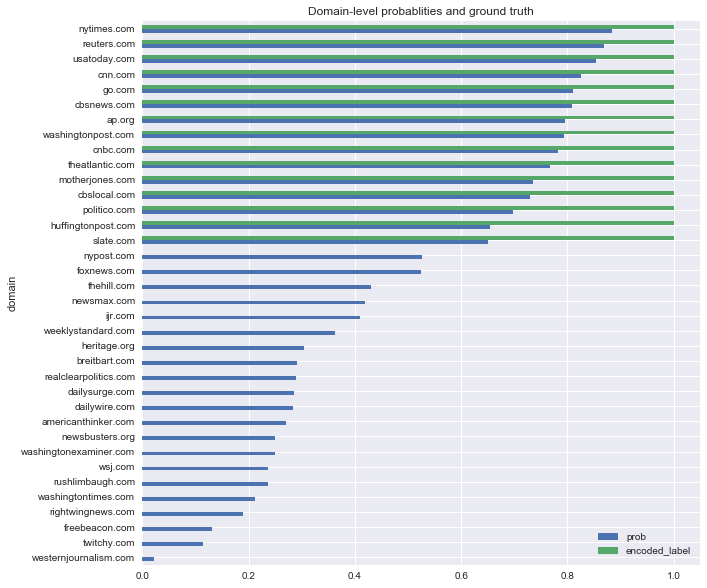

In [8]:
# Groupby domain name and take the average probability.  We can then round to 0/1 to 
# get a domain-level classification.

drop_less_than = 10  # Drop domains with fewer than this many observations

df_mean = df.groupby('domain')['encoded_label', 'prob'].mean()
df_count = df.groupby('domain')['domain'].count()
df_stats = pd.concat([df_mean, df_count], axis=1).sort_values('prob')
df_stats['num_correct'] = df_stats.apply(lambda x: int(np.round(x['prob'])) == x['encoded_label'], axis=1)
df_stats = df_stats[df_stats['domain'] >= drop_less_than]

_ = df_stats[['prob', 'encoded_label']].plot(kind='barh', figsize=(10,10), 
      title='Domain-level probablities and ground truth')

In [9]:
# Count the number of correct domain-level classifications.
tf = df_stats.groupby('num_correct')['prob'].count()
print('Domain-level accuracy: {:1.2f}%'.format(100.*tf[True]/tf.sum()))

Domain-level accuracy: 94.44%


### Sequence visualization

In [10]:
# Reload the model split as hidden and output layers.

model_emb, model_out = utils.split_model_layers(model, p)

In [11]:
# Helper function to compute sequence of probabilities per token.

def seq_proba(idx, print_=True):
  seq = utils.evaluate_sequential_probs(X, idx, model_emb, model_out)
  words = [idx2word[x] for x in X[idx, :].tolist()]
  if print_:
    print(df.iloc[idx, :])
  return seq, words

text              Opponents of French presidential candidate Mar...
label                                                  conservative
url               http://www.breitbart.com/london/2017/02/25/cam...
domain                                                breitbart.com
tokenized_text    opponent_NOUN french_ADJ presidential_ADJ cand...
encoded_text      [783, 1742, 117, 287, 1921, 2907, 3602, 1077, ...
encoded_label                                                     0
prob                                                       0.474671
Name: 20321, dtype: object


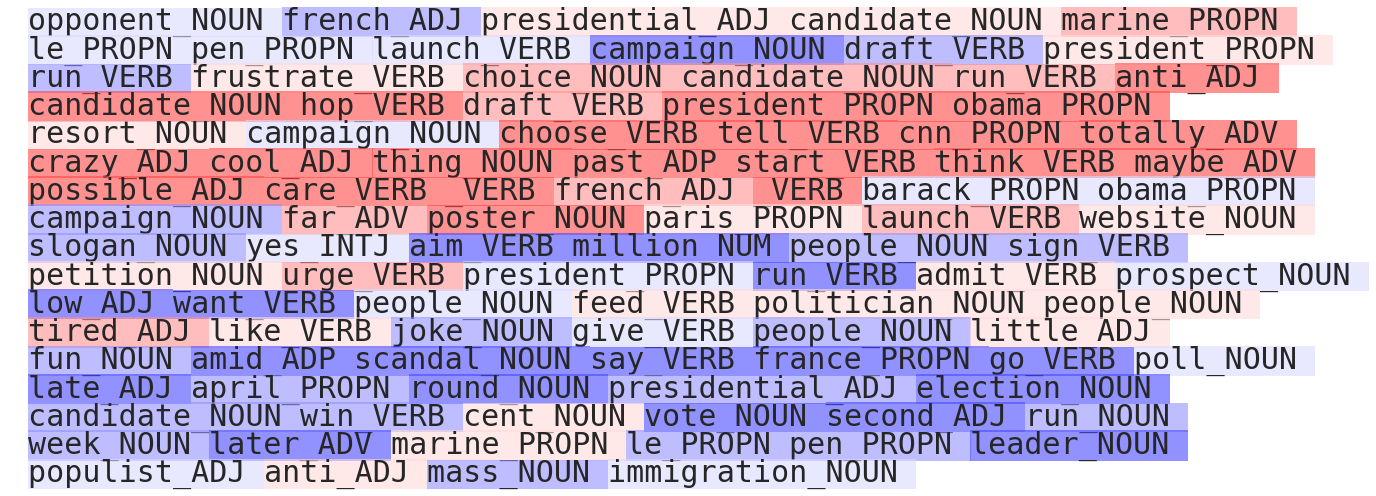

In [18]:
# Compute the sequence probablities and visualize.

seq, words = seq_proba(20321)
_, _ = pl.render(words, 1.-seq, fontsize=30)